In [8]:
import os, sys
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
import argparse
import time
import timm.optim.optim_factory as optim_factory
import datetime
import matplotlib.pyplot as plt
import wandb
import copy

from config import Config_MBM_fMRI
from dataset import hcp_dataset
from sc_mbm.mae_for_fmri import MAEforFMRI
from sc_mbm.trainer import train_one_epoch
from sc_mbm.trainer import NativeScalerWithGradNormCount as NativeScaler
from sc_mbm.utils import save_model

In [9]:
os.environ["WANDB_START_METHOD"] = "thread"
os.environ['WANDB_DIR'] = "."

class wandb_logger:
    def __init__(self, config):
        wandb.init(
                    project="mind-vis",
                    anonymous="allow",
                    group='stageA_sc-mbm',
                    config=config,
                    reinit=True)

        self.config = config
        self.step = None
    
    def log(self, name, data, step=None):
        if step is None:
            wandb.log({name: data})
        else:
            wandb.log({name: data}, step=step)
            self.step = step
    
    def watch_model(self, *args, **kwargs):
        wandb.watch(*args, **kwargs)

    def log_image(self, name, fig):
        if self.step is None:
            wandb.log({name: wandb.Image(fig)})
        else:
            wandb.log({name: wandb.Image(fig)}, step=self.step)

    def finish(self):
        wandb.finish(quiet=True)

In [4]:
def create_readme(config, path):
    print(config.__dict__)
    with open(os.path.join(path, 'README.md'), 'w+') as f:
        print(config.__dict__, file=f)

In [5]:
def fmri_transform(x, sparse_rate=0.2):
    # x: 1, num_voxels
    x_aug = copy.deepcopy(x)
    idx = np.random.choice(x.shape[0], int(x.shape[0]*sparse_rate), replace=False)
    x_aug[idx] = 0
    return torch.FloatTensor(x_aug)

In [6]:
config = Config_MBM_fMRI()

In [7]:
if torch.cuda.device_count() > 1:
    torch.cuda.set_device(config.local_rank) 
    torch.distributed.init_process_group(backend='nccl')
output_path = os.path.join(config.root_path, 'results', 'fmri_pretrain',  '%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S")))
# output_path = os.path.join(config.root_path, 'results', 'fmri_pretrain')
config.output_path = output_path
logger = wandb_logger(config) if config.local_rank == 0 else None

if config.local_rank == 0:
    os.makedirs(output_path, exist_ok=True)
    create_readme(config, output_path)

device = torch.device(f'cuda:{config.local_rank}') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(config.seed)
np.random.seed(config.seed)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zhaizhongyuan (11785-bhiksha). Use `wandb login --relogin` to force relogin


{'lr': 0.00025, 'min_lr': 0.0, 'weight_decay': 0.05, 'num_epoch': 500, 'warmup_epochs': 40, 'batch_size': 100, 'clip_grad': 0.8, 'mask_ratio': 0.75, 'patch_size': 16, 'embed_dim': 1024, 'decoder_embed_dim': 512, 'depth': 24, 'num_heads': 16, 'decoder_num_heads': 16, 'mlp_ratio': 1.0, 'root_path': '../', 'output_path': '../results/fmri_pretrain/13-11-2024-22-19-55', 'seed': 2022, 'roi': 'VC', 'aug_times': 1, 'num_sub_limit': None, 'include_hcp': True, 'include_kam': True, 'accum_iter': 1, 'use_nature_img_loss': False, 'img_recon_weight': 0.5, 'focus_range': None, 'focus_rate': 0.6, 'local_rank': 0}


In [7]:
torch.concatenate([torch.zeros(4, 5), torch.zeros(4, 5)], dim=1).shape

torch.Size([4, 10])

In [8]:
config.root_path = '../'

In [9]:
# create dataset and dataloader
dataset_pretrain = hcp_dataset(path=os.path.join(config.root_path, 'data/HCP/npz'), roi=config.roi, patch_size=config.patch_size,
            transform=fmri_transform, aug_times=config.aug_times, num_sub_limit=config.num_sub_limit, 
            include_kam=config.include_kam, include_hcp=config.include_hcp)

print(f'Dataset size: {len(dataset_pretrain)}\nNumber of voxels: {dataset_pretrain.num_voxels}')
sampler = torch.utils.data.DistributedSampler(dataset_pretrain, rank=config.local_rank) if torch.cuda.device_count() > 1 else None 

dataloader_hcp = DataLoader(dataset_pretrain, batch_size=config.batch_size, sampler=sampler, 
            shuffle=(sampler is None), pin_memory=True)

Dataset size: 6360
Number of voxels: 4656


In [10]:
dataset_pretrain[0]['image'].shape

torch.Size([3, 112, 112])

In [11]:
np.unique(dataset_pretrain[0]['image'])

array([0.], dtype=float32)

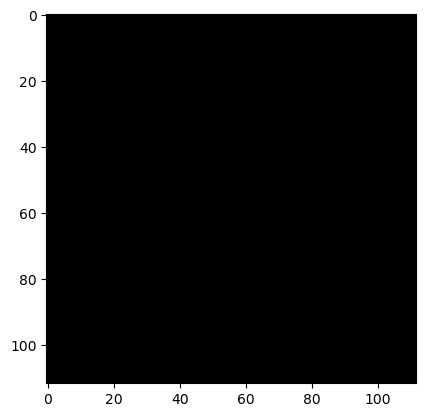

In [12]:
plt.imshow(np.transpose(dataset_pretrain[0]['image'], (1, 2, 0)))

In [13]:
len(dataset_pretrain)

6360

In [14]:
dataset_pretrain[0]['fmri'].shape

torch.Size([1, 4656])

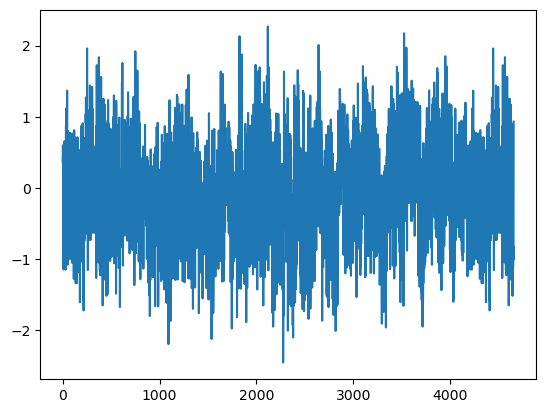

In [15]:
plt.plot(np.arange(len(dataset_pretrain[0]['fmri'].flatten())), dataset_pretrain[0]['fmri'].flatten())

In [16]:
len(dataset_pretrain[0]['fmri'].flatten())

4656

In [17]:
sampler = torch.utils.data.DistributedSampler(dataset_pretrain, rank=config.local_rank) if torch.cuda.device_count() > 1 else None 

dataloader_hcp = DataLoader(dataset_pretrain, batch_size=config.batch_size, sampler=sampler, 
            shuffle=(sampler is None), pin_memory=True)

In [18]:
# create model
config.num_voxels = dataset_pretrain.num_voxels
model = MAEforFMRI(num_voxels=dataset_pretrain.num_voxels, patch_size=config.patch_size, embed_dim=config.embed_dim,
                decoder_embed_dim=config.decoder_embed_dim, depth=config.depth, 
                num_heads=config.num_heads, decoder_num_heads=config.decoder_num_heads, mlp_ratio=config.mlp_ratio,
                focus_range=config.focus_range, focus_rate=config.focus_rate, 
                img_recon_weight=config.img_recon_weight, use_nature_img_loss=config.use_nature_img_loss)   
model.to(device)
model_without_ddp = model
if torch.cuda.device_count() > 1:
    model = torch.nn.SyncBatchNorm.convert_sync_batchnorm(model)
    model = DistributedDataParallel(model, device_ids=[config.local_rank], output_device=config.local_rank, find_unused_parameters=config.use_nature_img_loss)

param_groups = optim_factory.add_weight_decay(model, config.weight_decay)
optimizer = torch.optim.AdamW(param_groups, lr=config.lr, betas=(0.9, 0.95))
print(optimizer)
loss_scaler = NativeScaler()

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00025
    maximize: False
    weight_decay: 0.0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.00025
    maximize: False
    weight_decay: 0.05
)


/storage/ice1/1/7/zzhai37/nsp/mind-vis/code/sc_mbm/trainer.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


In [1]:
if logger is not None:
    logger.watch_model(model,log='all', log_freq=1000)

cor_list = []
start_time = time.time()
print('Start Training the fmri MAE ... ...')
img_feature_extractor = None
preprocess = None
if config.use_nature_img_loss:
    from torchvision.models import resnet50, ResNet50_Weights
    from torchvision.models.feature_extraction import create_feature_extractor
    weights = ResNet50_Weights.DEFAULT
    preprocess = weights.transforms()
    m = resnet50(weights=weights)   
    img_feature_extractor = create_feature_extractor(m, return_nodes={f'layer2': 'layer2'}).to(device).eval()
    for param in img_feature_extractor.parameters():
        param.requires_grad = False

NameError: name 'logger' is not defined

In [20]:
@torch.no_grad()
def plot_recon_figures(model, device, dataset, output_path, num_figures = 5, config=None, logger=None, model_without_ddp=None):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    model.eval()
    fig, axs = plt.subplots(num_figures, 3, figsize=(30,15))
    fig.tight_layout()
    axs[0,0].set_title('Ground-truth')
    axs[0,1].set_title('Masked Ground-truth')
    axs[0,2].set_title('Reconstruction')

    for ax in axs:
        sample = next(iter(dataloader))['fmri']
        sample = sample.to(device)
        _, pred, mask = model(sample, mask_ratio=config.mask_ratio)
        sample_with_mask = model_without_ddp.patchify(sample).to('cpu').numpy().reshape(-1, model_without_ddp.patch_size)
        pred = model_without_ddp.unpatchify(pred).to('cpu').numpy().reshape(-1)
        sample = sample.to('cpu').numpy().reshape(-1)
        mask = mask.to('cpu').numpy().reshape(-1)
        # cal the cor
        cor = np.corrcoef([pred, sample])[0,1]

        x_axis = np.arange(0, sample.shape[-1])
        # groundtruth
        ax[0].plot(x_axis, sample)
        # groundtruth with mask
        s = 0
        for x, m in zip(sample_with_mask,mask):
            if m == 0:
                ax[1].plot(x_axis[s:s+len(x)], x, color='#1f77b4')
            s += len(x)
        # pred
        ax[2].plot(x_axis, pred)
        ax[2].set_ylabel('cor: %.4f'%cor, weight = 'bold')
        ax[2].yaxis.set_label_position("right")

    fig_name = 'reconst-%s'%(datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
    fig.savefig(os.path.join(output_path, f'{fig_name}.png'))
    if logger is not None:
        logger.log_image('reconst', fig)
    plt.close(fig)

def update_config(args, config):
    for attr in config.__dict__:
        if hasattr(args, attr):
            if getattr(args, attr) != None:
                setattr(config, attr, getattr(args, attr))
    return config

In [22]:
config.num_epoch = 10

In [23]:
for ep in range(config.num_epoch):
    if torch.cuda.device_count() > 1: 
        sampler.set_epoch(ep) # to shuffle the data at every epoch
    cor = train_one_epoch(model, dataloader_hcp, optimizer, device, ep, loss_scaler, logger, config, start_time, model_without_ddp,
                        img_feature_extractor, preprocess)
    cor_list.append(cor)
    if (ep % 20 == 0 or ep + 1 == config.num_epoch) and ep != 0 and config.local_rank == 0:
        # save models
        save_model(config, ep, model_without_ddp, optimizer, loss_scaler, os.path.join(output_path,'checkpoints'))
        # plot figures
        plot_recon_figures(model, device, dataset_pretrain, output_path, 5, config, logger, model_without_ddp)
        
total_time = time.time() - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print('Training time {}'.format(total_time_str))
if logger is not None:
    logger.log('max cor', np.max(cor_list), step=config.num_epoch-1)
    logger.finish()

/storage/ice1/1/7/zzhai37/nsp/mind-vis/code/sc_mbm/trainer.py:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


[Epoch 0] loss: 1.477977312169969
[Epoch 1] loss: 0.8830457776784897
[Epoch 2] loss: 0.8576192958280444
[Epoch 3] loss: 0.8501766379922628
[Epoch 4] loss: 0.8490530531853437
[Epoch 5] loss: 0.8474541679024696
[Epoch 6] loss: 0.8490197267383337
[Epoch 7] loss: 0.8458540877327323
[Epoch 8] loss: 0.8482885481789708
[Epoch 9] loss: 0.8482541739940643
Training time 0:03:47


SyntaxError: 'return' outside function (1866882535.py, line 19)